# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import re
from tqdm import tqdm

%matplotlib inline

# Task 1

## Input data

In [19]:
def read_tsp(name='bays29'):
    dim = int(re.findall('\d+', name)[0])
    
    dist = np.zeros((dim, dim))
    coords = np.zeros((dim, 2))
    
    data_file = open(f'tsp/{name}.tsp.txt')
    lines = data_file.readlines()
    
    read_cords = False
    read_dists = False
    i = 0
    
    for line in lines:
        if read_cords and i < dim:
            coords[i, :] = (line.split()[1:])
            i += 1
        elif read_dists and i < dim:
            dist[i] = line.split()
            i += 1
        elif re.findall('EDGE_WEIGHT_SECTION', line) and name == 'bays29': # only non euclidean distance matrix
            read_dists = True
            i = 0
        elif re.findall('SECTION', line) and not re.findall('WEIGHT', line):
            read_cords = True
            i = 0
    
    coords = coords.astype(int)
    
    if not read_dists:
        for i in range(dim):
            for j in range(dim):
                dist[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
                
    data_file.close()
    
    opt = None
    
    try:     
        opt_file = open(f'tsp/{name}.opt.tour.txt')
        lines = opt_file.readlines()
        
        read_opt = False
        i = 0
        opt = np.zeros(dim, dtype=int)
        
        for line in lines:
            if read_opt and i < dim:
                opt[i] = int(line) - 1
                i += 1
            elif re.findall('TOUR_SECTION', line):
                read_opt = True
                
        opt_file.close()
    except FileNotFoundError:
        warnings.warn("No optimal solution supplied!")
        
    return coords, dist, opt

In [20]:
coords, A, p = read_tsp('berlin52')
n = 52

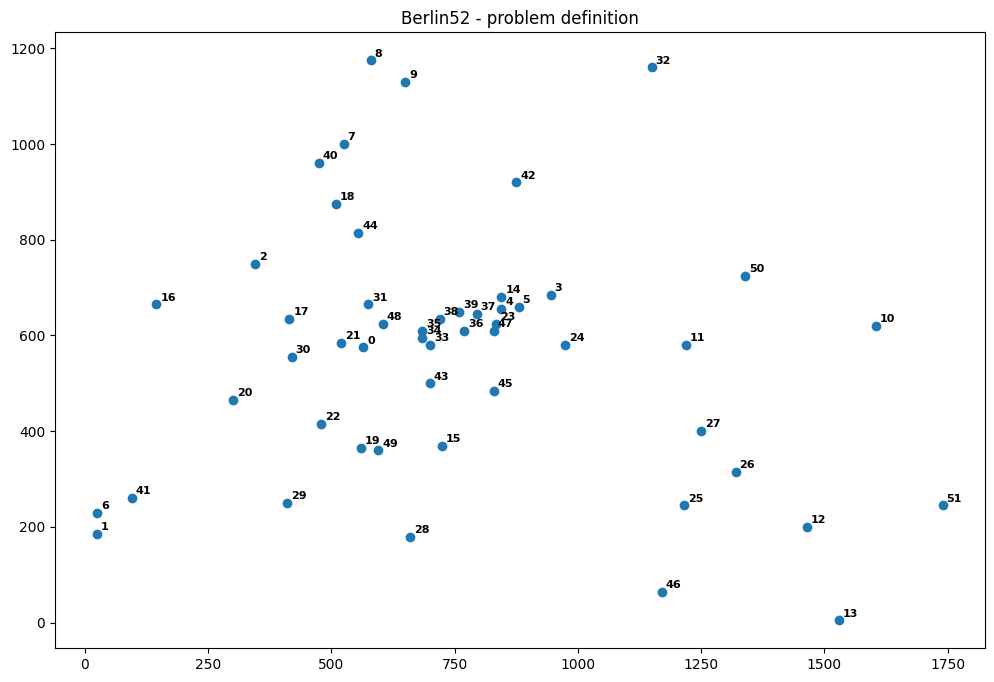

In [4]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

<Figure size 1200x800 with 0 Axes>

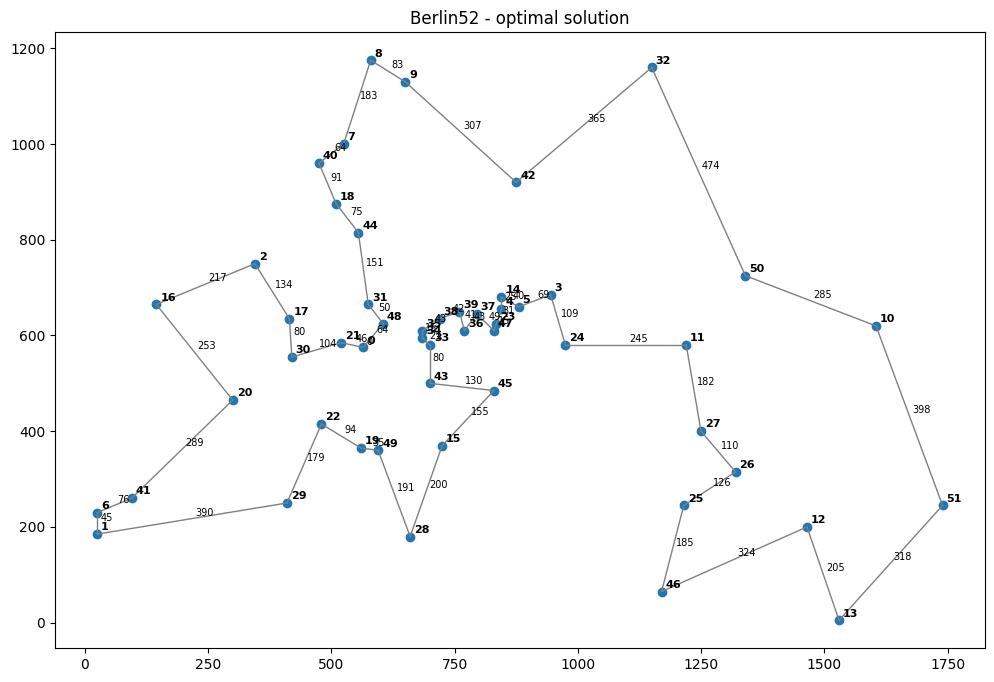

In [5]:
from matplotlib.lines import Line2D

route = p

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(1, len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

plt.title('Berlin52 - optimal solution')

plt.show()

## Objective function

In [21]:
from numba import njit

@njit
def tsp_objective_function(p, A=A):
    s = 0.0
    for i in range(A.shape[0]):
        s += A[p[i-1], p[i]]
    return s

In [137]:
print(tsp_objective_function(p), p)

9020.29642913096 [31 48 35 34 33 38 39 42 32 50 10 11 45 15 28 49 19 22 29  1  6 41 20 16
  2 17 30 21  0 43 25 46 13 51 12 26 27 24  3  5 14  4 23 47 36 37  9  8
  7 40 18 44]


## Random Sampling

In [8]:
t0 = time.time()

T = 1000000

permutations = np.empty((T, n), dtype=np.int64)
costs = np.zeros(T)
for i in range(T):
    permutations[i, :] = np.random.permutation(n)
    costs[i] = tsp_objective_function(permutations[i, :])

print(time.time() - t0)

p = permutations[costs.argmin(), :]
print(tsp_objective_function(p), p)

34.40341401100159
21621.138568286235 [29  1 33  8  7  6 16 40  9 23 36 15 31 41 50 38 43 37 45  4 10 44 14  2
 18 28 19 21  0 22 25 13 46 26 12 49 34  5 11  3 39 35 42 32 47 27 51 24
 20 30 17 48]


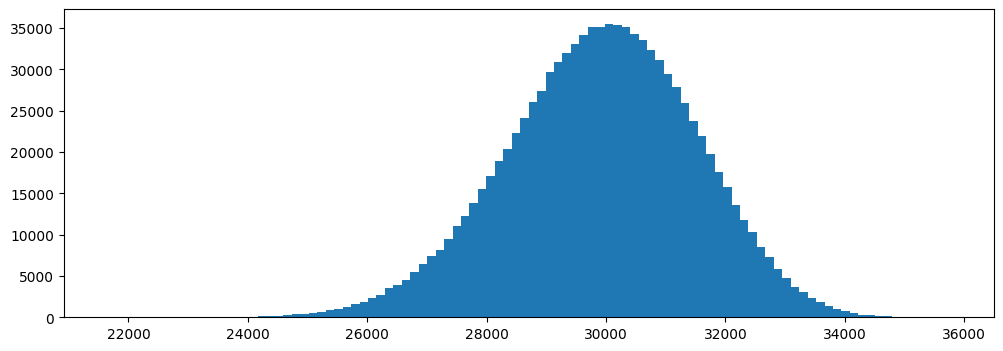

29910.385488256827 1580.7074382972355


In [9]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [74]:
def random_neighbor(p, radius=1):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [11]:
T = 500000
radius = 1
alpha = 1.0

t0 = time.time()

p = np.random.permutation(n)
p_cost = tsp_objective_function(p)
costs = np.zeros(T)
for t in range(T):
    q = random_neighbor(p, radius)
    q_cost = tsp_objective_function(q)
    if(q_cost < p_cost):
        p, p_cost = q, q_cost
    elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
        p, p_cost = q, q_cost
    costs[t] = p_cost

print(time.time() - t0, costs.min())

29.120709896087646 9020.29642913096


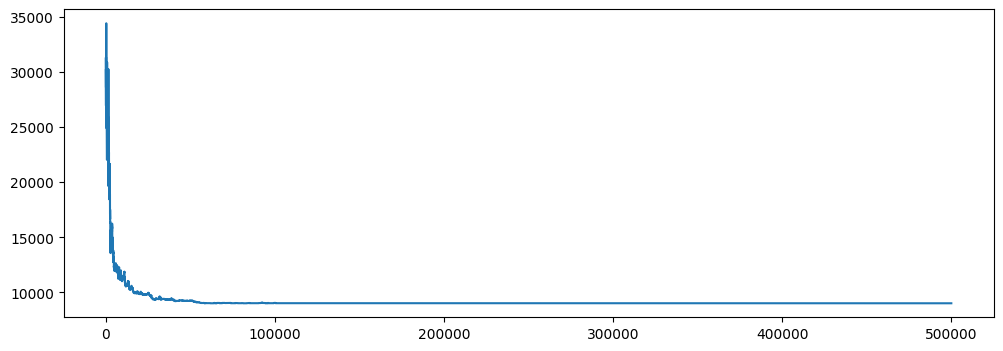

In [12]:
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

## SGA-PMX

In [7]:
import numpy as np

def resolve_conflict(element, child, mapping):
    while element in child:
        element = mapping[element]
        
    return element

def PMX(parent1, parent2, k=26):
    assert parent1.shape == parent2.shape
    
    size = parent1.size
    selected = np.random.choice(size, size=k, replace=False)
    
    # Initialize children with -1
    ch1, ch2 = np.full(size, -1, dtype=np.int64), np.full(size, -1, dtype=np.int64)
    
    # Swap the selected elements
    ch1[selected], ch2[selected] = parent2[selected], parent1[selected]
    
    # Create dictionaries for mapping
    d1 = {b: a for a, b in zip(parent1[selected], parent2[selected])}
    d2 = {a: b for a, b in zip(parent1[selected], parent2[selected])}
    
    for i in range(size):
        if i not in selected:
            if parent1[i] not in ch1:
                ch1[i] = parent1[i]
            else:
                ch1[i] = resolve_conflict(parent1[i], ch1, d1)
            
            if parent2[i] not in ch2:
                ch2[i] = parent2[i]
            else:
                ch2[i] = resolve_conflict(parent2[i], ch2, d2)

    return ch1, ch2


In [37]:
# Test
parent1 = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
parent2 = np.array([9, 8, 7, 6, 5, 4, 3, 2, 1])

offspring1, offspring2 = PMX(parent1, parent2, k=2)
print("Offspring 1:", offspring1)
print("Offspring 2:", offspring2)

Offspring 1: [9 2 7 4 5 6 3 8 1]
Offspring 2: [1 8 3 6 5 4 7 2 9]


In [8]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [124]:

def SGA(
    population_size=500,
    chromosome_length=52,
    number_of_offspring=500,
    crossover_operator=PMX,
    crossover_probability=0.80,
    mutation_probability=0.15,
    mutation_f=reverse_sequence_mutation,
    number_of_iterations=300,
    k=52//10,
    dists=A,
    extra_mutation=None,
    neighbourhood_size=2,
):
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    costs=np.zeros(number_of_iterations)
    stds=np.zeros(number_of_iterations)

    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :], A=dists)

    for t in tqdm(range(number_of_iterations)):
        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = crossover_operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy(), k=k)
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation_f(children_population[i, :])

        if extra_mutation:
            for i in range(number_of_offspring):
                children_population[i, :] = extra_mutation(children_population[i, :], k=neighbourhood_size, dists=dists)

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :], A=dists)

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        costs[t] = best_objective_value
        stds[t] = objective_values.std()

    return costs, stds

In [68]:
coords, dists, opt = read_tsp('berlin52')
costs, stds = SGA(
    population_size=500,
    chromosome_length=coords.shape[0],
    number_of_offspring=500,
    crossover_probability=0.99,
    mutation_probability=0.55,
    number_of_iterations=300,
    k=coords.shape[0]//10,
    dists=dists
)

100%|██████████| 300/300 [00:58<00:00,  5.09it/s]


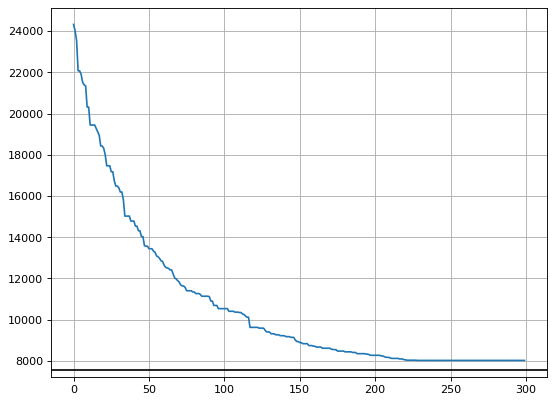

Optimal: 7544.365901904086
Achieved: 
 min: 8024.221812518802
 mean: 10631.077460225366
 std: 3631.9450206544802


In [69]:
plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
plt.plot(costs)
plt.axhline(y=tsp_objective_function(opt, dists), color = 'black', linestyle = '-')
plt.show()

print("Optimal:", tsp_objective_function(opt, dists))
print(f"Achieved: \n min: {costs.min()}\n mean: {costs.mean()}\n std: {costs.std()}")

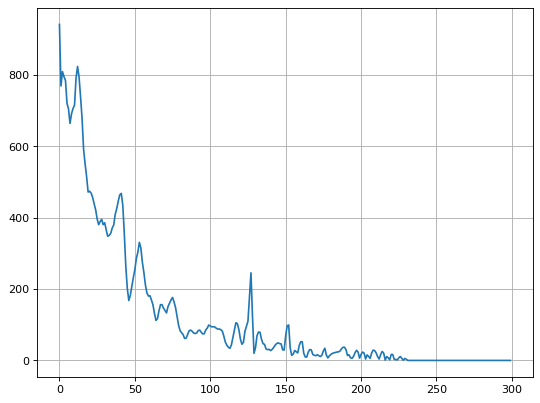

In [70]:
plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
plt.plot(stds)
plt.show()

## Subpoint D

In [81]:
coords, dists, opt = read_tsp('berlin52')
costs, stds = SGA(
    population_size=500,
    chromosome_length=coords.shape[0],
    number_of_offspring=500,
    crossover_probability=0.99,
    mutation_probability=0.55,
    mutation_f=random_neighbor,
    number_of_iterations=300,
    k=coords.shape[0]//10,
    dists=dists
)

100%|██████████| 300/300 [01:12<00:00,  4.13it/s]


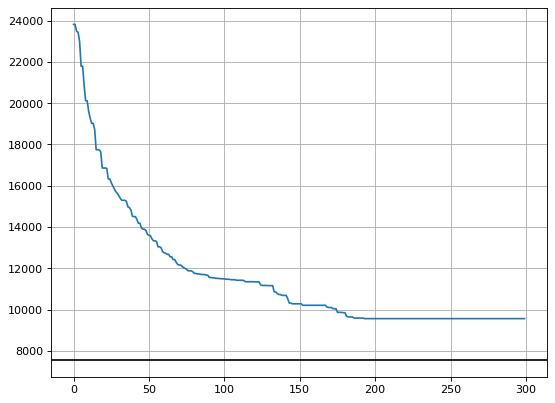

Optimal: 7544.365901904086
Achieved: 
 min: 9568.57553911846
 mean: 11591.582351303416
 std: 2963.634139766956


In [82]:
plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
plt.plot(costs)
plt.axhline(y=tsp_objective_function(opt, dists), color = 'black', linestyle = '-')
plt.show()

print("Optimal:", tsp_objective_function(opt, dists))
print(f"Achieved: \n min: {costs.min()}\n mean: {costs.mean()}\n std: {costs.std()}")

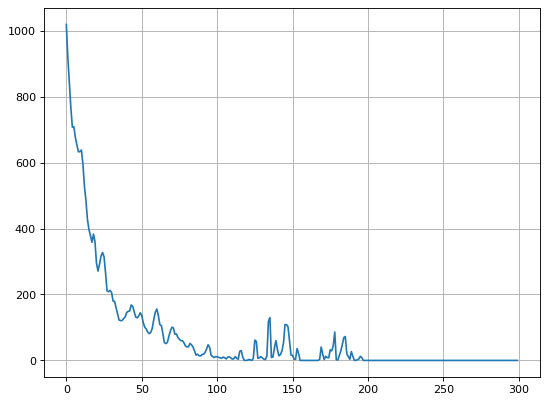

In [83]:
plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
plt.plot(stds)
plt.show()

## Subpoint E

In [104]:
costs, stds=[],[]
optims=[]
instances=[ 'bayg29', 'bays29', 'berlin52', 'kroA100','kroA150', 'kroA200']
T=3
number_of_iterations=300

for problem in instances:
    print(problem)
    cost=np.zeros((T, number_of_iterations))
    std=np.zeros((T, number_of_iterations))
    
    coords, dists, opt = read_tsp(problem)

    optims.append(tsp_objective_function(opt, dists) if not isinstance(opt, type(None)) else None)
        
    for t in range(T):
        c, s = SGA(
            population_size=500,
            chromosome_length=coords.shape[0],
            number_of_offspring=500,
            crossover_probability=0.95,
            mutation_probability=0.1,
            number_of_iterations=number_of_iterations,
            k=coords.shape[0]//4,
            dists=dists
        )
        cost[t, :] = c
        std[t, :] = s
        
    costs.append(cost)
    stds.append(std)

bayg29


100%|██████████| 300/300 [00:21<00:00, 13.86it/s]


bays29


100%|██████████| 300/300 [00:25<00:00, 11.64it/s]


berlin52


100%|██████████| 300/300 [00:55<00:00,  5.43it/s]


kroA100


100%|██████████| 300/300 [02:44<00:00,  1.82it/s]


kroA150


/tmp/ipykernel_10096/2862251678.py:56: UserWarning: No optimal solution supplied!
  warnings.warn("No optimal solution supplied!")
100%|██████████| 300/300 [02:10<00:00,  2.31it/s]


kroA200


100%|██████████| 300/300 [02:06<00:00,  2.37it/s]


In [105]:
for i in range(len(instances)):
    print(instances[i])
    print(f'Optimal: {optims[i]}, best solution: {np.min(costs[i]):.2f}')

bayg29
Optimal: 9074.148047872843, best soluction: 9140.50
bays29
Optimal: 2020.0, best soluction: 2065.00
berlin52
Optimal: 7544.365901904086, best soluction: 8108.79
kroA100
Optimal: 21285.44318157108, best soluction: 28197.01
kroA150
Optimal: None, best soluction: 61513.79
kroA200
Optimal: None, best soluction: 98314.37


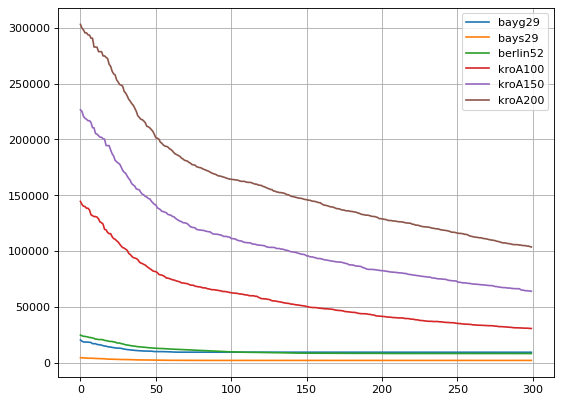

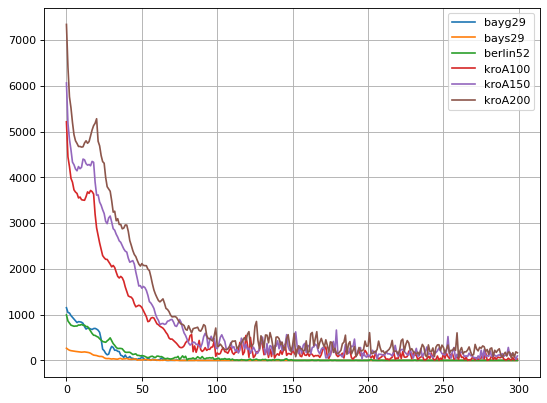

In [107]:
plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
for c in costs:    
    plt.plot(np.average(c, axis=0))
    
plt.legend(instances)
plt.show()

plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
for s in stds:
    plt.plot(np.average(s, axis=0))
    
plt.legend(instances)
plt.show()

# Task 2

## Cyclic Crossover (CX):
Objective: To preserve the relative order of elements from the parents.

Process:
1. Cycle Identification: Start with the smallest element of Parent 1 (or choose randomly). Find the element in the same position in Parent 2. Then, find the element in Parent 1 that is in the position where the second element was in Parent 2. Continue this process until you return to the starting element. This forms a cycle.
2. Offspring Creation: The elements that are part of this cycle are copied directly from Parent 1 to Offspring 1. The remaining elements are filled in from Parent 2. For Offspring 2, the process is reversed (the cycle elements come from Parent 2, and the rest from Parent 1).
3. Characteristics: This method ensures that each offspring is a unique permutation and preserves the position of the elements from the parents.

## Order Crossover (OX):
Objective: To maintain the sequence/order of a subset of elements from the parents.

Process:

1. Segment Selection: Randomly select a subset (slice) from Parent 1. This subset will be directly copied to the offspring.
2. Offspring Filling: Starting from the end of the segment, fill the rest of the offspring with the elements from Parent 2, skipping those already included in the segment. Ensure the sequence from Parent 2 is maintained.
3. Creating Second Offspring: Repeat the process with roles of Parent 1 and Parent 2 reversed.
4. Characteristics: OX is beneficial in problems where the order of elements is important. It helps in preserving the sequence of the elements from the parents.

## Comparison:
- Preservation of Order: CX focuses on preserving the relative positions of elements from the parents, while OX emphasizes preserving the sequence of a subset of elements.
- Applicability: CX is more suited to problems where the position of each element is crucial, whereas OX is useful when the sequence of a group of elements matters.

In [12]:
def CX(parent1, parent2, k=None):
    assert(parent1.shape == parent2.shape)
    
    parents = np.vstack((parent1, parent2))
    
    size = parent1.size
    child1 = np.full(size, -1, dtype=np.int64)
    child2 = np.zeros(size, dtype=np.int64)
    
    while -1 in child1:
        i = np.argmin(child1)
        parent = 1 if np.random.rand() < 0.5 else 0
        
        while child1[i] == -1:
            child1[i] = parents[parent][i]
            child2[i] = parents[1 - parent][i]
            i = np.where(parents[1 - parent, :] == child1[i])[0].item()
            
    return child1, child2

In [13]:
def OX(parent1, parent2, k=26):
    assert(parent1.shape == parent2.shape)
    
    size = parent1.size
    selected = np.random.choice(size, size=k, replace=False)
    
    ch1 = np.full(size, -1, dtype=np.int64)
    ch2 = np.full(size, -1, dtype=np.int64)
    
    ch1[selected] = parent1[selected]
    ch2[selected] = parent2[selected]
    
    queue = []
    start = max(selected) + 1
    
    for i in range(size):
        queue.append(parent2[(start + i) % size])
        
    queue = list(set(queue) - set(ch1))
    
    for i in range(size):
        idx = start+i
        
        if ch1[idx % size] == -1:
            ch1[idx % size] = queue.pop(0)
            
    assert(queue == [])
    
    for i in range(size):
        queue.append(parent1[(start + i) % size])
        
    queue = list(set(queue) - set(ch2))
    
    for i in range(size):
        idx = start + i
        
        if ch2[idx % size] == -1:
            ch2[idx % size] = queue.pop(0)
            
    assert(queue == [])
        
    return ch1, ch2

## Displacement Mutation:
Description: In Displacement Mutation, a subsequence is selected from the sequence and removed. The removed subsequence is then inserted back into the original sequence at a different position.

Process:
1. Subsequence Selection: Randomly choose a continuous subsequence from the sequence.
2. Removal: Remove this subsequence from its current position.
3. Reinsertion: Insert the removed subsequence at a different randomly selected position in the sequence.
Purpose: This mutation method is designed to change the order of elements in the sequence while preserving the actual elements and their relative order within the displaced subsequence.

## Insertion Mutation:
Description: Insertion Mutation involves selecting an element from the sequence and inserting it into a different position, effectively shifting the rest of the elements to accommodate the insertion.

Process:
1. Element Selection: Randomly select one element from the sequence.
2. New Position Identification: Randomly choose a new position in the sequence (different from the element’s current position).
3. Insertion: Remove the selected element from its current position and insert it into the chosen new position.
Purpose: The goal of Insertion Mutation is to alter the relative positioning of elements within the sequence, which can lead to significant changes in the solution structure, depending on the problem being solved.

Comparison:
- Preservation of Sequence Order: Displacement Mutation maintains the relative order of a subset of elements when they are reinserted, while Insertion Mutation may change this order by moving a single element.
- Impact on Solution: Displacement Mutation can have a more substantial impact on the solution structure since it involves moving multiple elements. In contrast, Insertion Mutation typically has a more localized effect.

In [11]:
def displacement_mutation(p):
    a = np.random.choice(len(p) - 1, 2, False)
    
    i, j = a.min(), a.max()
    pom = p[i:j+1]
    
    q = np.delete(p, np.arange(i, j+1))
    
    idx = np.random.choice(q.size)
    q = np.insert(q, idx, pom)
    
    return q

def insertion_mutation(p):
    i = np.random.choice(p.size)
    q = np.delete(p, i)
    q = np.insert(q, np.random.choice(q.size), p[i])
    
    return q

In [117]:
import itertools

costs, stds =[], []
crossovers = [PMX, OX, CX]
mutations = [reverse_sequence_mutation, displacement_mutation, insertion_mutation]
legend = list(itertools.product(['PMX', 'OX', 'CX'], ['reverse', 'displacement', 'insertion']))
variants = list(itertools.product(crossovers, mutations))

T = 3
iters = 500

for crossover, mutation in variants:
    print(f'{crossover.__name__} + {mutation.__name__}')
    cost = np.zeros((T, iters))
    std = np.zeros((T, iters))
    
    for t in range(T):
        c, s = SGA(
            population_size=500,
            chromosome_length=coords.shape[0],
            number_of_offspring=500,
            crossover_operator=crossover,
            crossover_probability=0.95,
            mutation_probability=0.1,
            mutation_f=mutation,
            number_of_iterations=iters,
            k=coords.shape[0]//4,
            dists=dists
        )
        cost[t, :] = c
        std[t, :] = s
        
    costs.append(cost)
    stds.append(std)

PMX + reverse_sequence_mutation


100%|██████████| 500/500 [03:58<00:00,  2.10it/s]


PMX + displacement_mutation


100%|██████████| 500/500 [06:12<00:00,  1.34it/s]


PMX + insertion_mutation


100%|██████████| 500/500 [06:40<00:00,  1.25it/s]


OX + reverse_sequence_mutation


100%|██████████| 500/500 [02:54<00:00,  2.86it/s]


OX + displacement_mutation


100%|██████████| 500/500 [03:05<00:00,  2.70it/s]


OX + insertion_mutation


100%|██████████| 500/500 [02:17<00:00,  3.62it/s]


CX + reverse_sequence_mutation


100%|██████████| 500/500 [07:40<00:00,  1.09it/s]


CX + displacement_mutation


100%|██████████| 500/500 [06:56<00:00,  1.20it/s]


CX + insertion_mutation


100%|██████████| 500/500 [08:19<00:00,  1.00it/s]


In [118]:
for c in costs:
    print(np.min(c, axis=1))

[69276.48075717 72581.65346186 70792.56346932]
[84919.36835646 79737.24478809 75832.22131935]
[95725.6290846  90332.7124787  91901.91688425]
[247860.103529   255698.43434839 253504.9656215 ]
[239570.86203422 238621.38934618 235926.74256553]
[249720.73024449 245864.58448647 238703.98788006]
[78043.20284304 70986.6130862  75650.55756858]
[85848.73478238 82407.04419583 83320.78595577]
[90520.72904364 90297.75667106 86722.50220751]


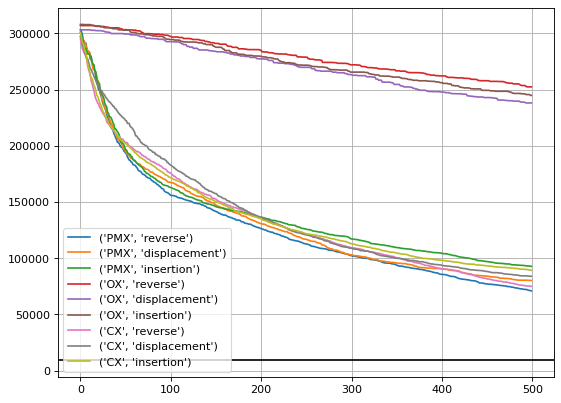

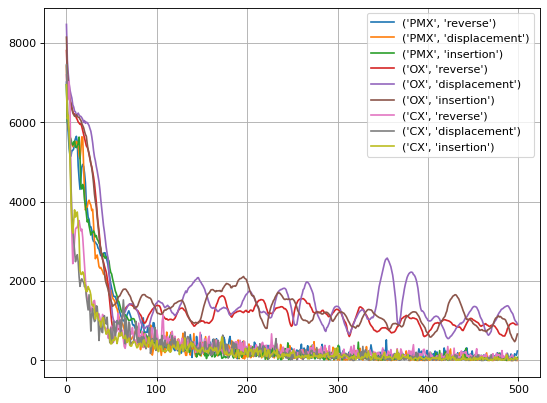

In [119]:
plt. figure(figsize=(8, 6), dpi=80)

plt.grid()
for c in costs:    
    plt.plot(np.average(c, axis=0))
    
if p is not None:
    plt.axhline(y = tsp_objective_function(p), color = 'black', linestyle = '-')
    
plt.legend(legend)
plt.show()

plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
for s in stds:
    plt.plot(np.average(s, axis=0))
    
plt.legend(legend)
plt.show()

# Task 3

In [138]:
from numba import njit

@njit
def random_neighbour(p, radius=2):
    q = p.copy()
    
    n = len(p)
    idxs = np.random.choice(n, radius, replace=False)
    vals = q[idxs]
    
    order = np.random.permutation(radius)
    
    for i in range(radius):
        q[idxs[i]] = vals[order[i]]
        
    return q

@njit
def neighbourhood(p, k=2):
    n = len(p)
    neighbours = [p]
    
    for radius in range(1, k):
        for i in range(n):
            for j in range(i+1,n):
                q = p.copy()
                q[i], q[j] = q[j], q[i]
                
                neighbours.append(q)
                
    return np.array(neighbours)

@njit
def neighbourhood(p, k=2, no=1e3):
    n = len(p)
    neighbours = [p]
    
    for radius in range(1, k):
        for i in range(n):
            for j in range(i+1, n):
                q = p.copy()
                q[i], q[j] = q[j], q[i]
                neighbours.append(q)
                
    return neighbours

@njit
def mutate_neighbourhood_once(p, k=2, dists=A):
    neighbours = neighbourhood(p, k)
    tsp_p = tsp_objective_function(p, dists)

    for i in range(neighbours.shape[0]):
        if tsp_objective_function(neighbours[i]) < tsp_p:
            p = neighbours[i]
            tsp_p = tsp_objective_function(p, dists)
            
    return p

In [140]:
coords, dists, opt = read_tsp('berlin52')
costs, stds = SGA(
    population_size=300,
    chromosome_length=coords.shape[0],
    number_of_offspring=300,
    crossover_probability=0.5,
    mutation_probability=0.3,
    mutation_f=random_neighbor,
    number_of_iterations=500,
    k=coords.shape[0]//4,
    dists=dists,
    extra_mutation=mutate_neighbourhood_once,
    neighbourhood_size=n//10,
)

100%|██████████| 500/500 [32:01<00:00,  3.84s/it]


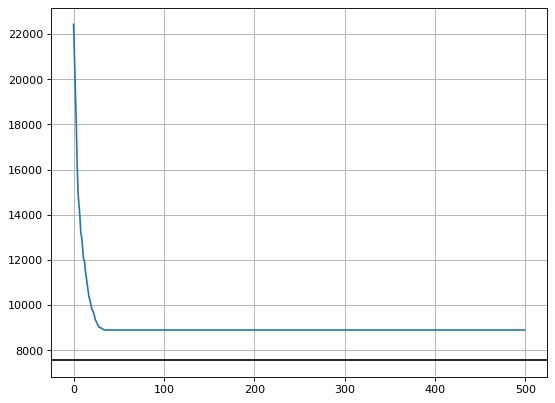

Optimal: 7544.365901904086
Achieved: 
 min: 8892.30381649576
 mean: 9102.384742151542
 std: 1214.9158508433304


In [141]:
plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
plt.plot(costs)
plt.axhline(y=tsp_objective_function(opt, dists), color = 'black', linestyle = '-')
plt.show()

print("Optimal:", tsp_objective_function(opt, dists))
print(f"Achieved: \n min: {costs.min()}\n mean: {costs.mean()}\n std: {costs.std()}")

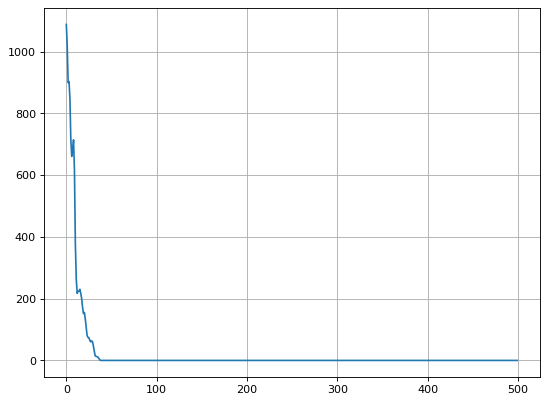

In [142]:
plt.figure(figsize=(8, 6), dpi=80)

plt.grid()
plt.plot(stds)
plt.show()

# Task 4

# Quadratic Assignment Problem (QAP)

The Quadratic Assignment Problem (QAP) is a fundamental problem in combinatorial optimization. It involves assigning a set of facilities to a set of locations with the goal of minimizing the total cost associated with the assignment. This cost is typically defined by the flow between facilities and the distance between locations. The QAP is known to be NP-hard, which means that there is no known efficient algorithm to solve it in polynomial time for all instances.

## Problem Definition

**Given:**
- A set of $( n )$ facilities and a set of $( n )$ locations.
- A flow matrix $( F = [f_{ij}] )$ of size $( n \times n )$, where $( f_{ij} )$ represents the flow between facility \( i \) and facility \( j \).
- A distance matrix $( D = [d_{kl}] )$ of size $( n \times n )$, where $( d_{kl} )$ represents the distance between location $( k )$ and location $( l )$.

**Objective:**
- To find a permutation $( \pi )$ that minimizes the total cost, calculated as:

  $$ \text{Cost}(\pi) = \sum_{i=1}^{n} \sum_{j=1}^{n} f_{ij} \cdot d_{\pi(i)\pi(j)} $$

In this formula, $( \pi(i) )$ denotes the location of facility $( i )$ in the permutation $( \pi )$.

## Characteristics

1. **NP-Hardness**: The QAP is challenging to solve exactly for large instances due to its NP-hard nature.

2. **Applications**: The QAP is applied in various fields like facility layout planning, keyboard layout optimization, scheduling problems, etc.

3. **Solution Methods**: For large instances, heuristic and metaheuristic approaches like genetic algorithms, tabu search, and simulated annealing are often used.

4. **Special Cases**: Some specific instances of the QAP can be more or less challenging depending on the structure of the flow and distance matrices.

The QAP represents a significant and challenging problem in the field of optimization, with a wide range of practical applications. Its complexity often requires advanced algorithmic approaches, especially for large problem instances.


In [2]:
qaps = {
    'nug12':  [ 578   ,   [12,7,9,3,4,8,11,1,5,6,10,2]],
    'nug14':  [ 1014   ,  [9,8,13,2,1,11,7,14,3,4,12,5,6,10]],
    'nug15':  [ 1150     ,[1,2,13,8,9,4,3,14,7,11,10,15,6,5,12]],
    'nug16a': [ 1610    , [9,14,2,15,16,3,10,12,8,11,6,5,7,1,4,13]],
    'nug16b': [ 1240,     [16,12,13,8,4,2,9,11,15,10,7,3,14,6,1,5]],
    'nug17':  [ 1732 ,    [16,15,2,14,9,11,8,12,10,3,4,1,7,6,13,17,5]],
    'nug18':  [ 1930  ,   [10,3,14,2,18,6,7,12,15,4,5,1,11,8,17,13,9,16]],
    'nug20':  [ 2570   ,  [18,14,10,3,9,4,2,12,11,16,19,15,20,8,13,17,5,7,1,6]],
    'nug21':  [ 2438    , [4,21,3,9,13,2,5,14,18,11,16,10,6,15,20,19,8,7,1,12,17] ],
    'nug22':  [ 3596    , [2,21,9,10,7,3,1,19,8,20,17,5,13,6,12,16,11,22,18,14,15] ],
    'nug24':  [ 3488    , [17,8,11,23,4,20,15,19,22,18,3,14,1,10,7,9,16,21,24,12,6,13,5,2]],
    'nug25':  [ 3744,     [5,11,20,15,22,2,25,8,9,1,18,16,3,6,19,24,21,14,7,10,17,12,4,23,13]],
    'nug27':  [ 5234,     [23,18,3,1,27,17,5,12,7,15,4,26,8,19,20,2,24,21,14,10,9,13,22,25,6,16,11]],
    'tai50a': [ 4941410,  []],
    'tai60a': [ 7208572,  []],
    'tai80a': [ 13557864, []]
}

In [3]:
def read_qap(name='nug12'):
    qap_instance_file = open(f'qap/{name}.dat')

    line = qap_instance_file.readline()
    n = int(line)

    A = np.zeros((n, n))
    i = 0
    while i < n:
        line = qap_instance_file.readline()
        pom = list(map(int, line.split()))
        
        if pom == []:
            continue
            
        A[i, :] = pom
        i += 1

    B = np.zeros((n, n))
    
    i = 0
    while i < n:
        line = qap_instance_file.readline()
        pom= list(map(int, line.split()))
        
        if not pom:
            continue
            
        B[i, :] = pom
        i += 1
        
    qap_instance_file.close()
    
    opt = qaps[name][0]
    
    return A, B, opt

In [4]:
def qap_objective_function(p, A, B):
    s = 0.0
    
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
        
    return s

In [5]:
a, b, p = read_qap()

In [9]:
def SGA_QAP(
    population_size=500,
    chromosome_length=52,
    number_of_offspring=500,
    crossover_operator=PMX,
    crossover_probability=0.80,
    mutation_probability=0.15,
    mutation_f=reverse_sequence_mutation,
    number_of_iterations=300,
    k=52 // 10,
    A=a,
    B=b,
    early_stopping=0
):
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))

    costs = np.zeros(number_of_iterations)
    stds = np.zeros(number_of_iterations)
    costs[:] = np.NaN
    stds[:] = np.NaN

    # Generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # Evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = qap_objective_function(current_population[i, :], A, B)

    for t in tqdm(range(number_of_iterations)):

        # Selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # Creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring / 2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = crossover_operator(
                    current_population[parent_indices[2*i], :].copy(),
                    current_population[parent_indices[2*i+1], :].copy(),
                    k=k
                )
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()

        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # Mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = mutation_f(children_population[i, :])

        # Evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = qap_objective_function(children_population[i, :], A, B)

        # Replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # Recording some statistics
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
            
        costs[t] = best_objective_value
        stds[t] = objective_values.std()
        
        # Early stopping condition
        if early_stopping > 0 and t > 2 * early_stopping and np.average(costs[t - 2 * early_stopping:t - early_stopping]) <= np.average(costs[t - early_stopping:t]):
            break
    
    return costs, stds

In [16]:
costs_stds_dict={}

In [23]:
import itertools

costs, stds = [], []
optims = []
instances = ['nug12', 'nug14', 'nug14', 'nug15', 'nug16a', 'nug16b', 'nug17', 'nug18', 'nug20', 'nug21', 'nug22', 'nug24', 'nug25', 'nug27']
number_of_iterations = 300
population_size = 500
T = 3

crossovers=[PMX, CX]
mutations=[reverse_sequence_mutation, displacement_mutation, insertion_mutation]
legend=list(itertools.product(['PMX', 'CX'], ['reverse', 'displacement', 'insertion']))

for problem in instances:
    print(problem)
    a, b, opt = read_qap(problem)
    n = a.shape[0]
    
    for crossover, mutation in itertools.product(crossovers, mutations):
        cost=np.zeros((T, number_of_iterations))
        std=np.zeros((T, number_of_iterations))
        
        for t in range(T):
            c, s = SGA_QAP(
                population_size=population_size,
                chromosome_length=n,
                number_of_offspring=population_size,
                crossover_operator=crossover,
                crossover_probability=0.95,
                mutation_f=mutation,
                mutation_probability=0.1,
                number_of_iterations=number_of_iterations,
                k=n//4,
                A=a,
                B=b,
                early_stopping=(number_of_iterations*n)//20
            )
            cost[t, :] = c
            std[t, :] = s
            
        costs.append(cost)
        stds.append(std)
        
    costs_stds_dict[problem] = [costs, stds]

nug12


100%|██████████| 300/300 [00:50<00:00,  5.99it/s]


nug14


100%|██████████| 300/300 [00:32<00:00,  9.24it/s]


nug14


100%|██████████| 300/300 [00:28<00:00, 10.67it/s]


nug15


100%|██████████| 300/300 [00:30<00:00,  9.95it/s]


nug16a


100%|██████████| 300/300 [00:23<00:00, 12.51it/s]


nug16b


100%|██████████| 300/300 [00:20<00:00, 14.47it/s]


nug17


100%|██████████| 300/300 [00:21<00:00, 13.86it/s]


nug18


100%|██████████| 300/300 [00:22<00:00, 13.22it/s]


nug20


100%|██████████| 300/300 [00:25<00:00, 11.94it/s]


nug21


100%|██████████| 300/300 [00:23<00:00, 12.51it/s]


nug22


100%|██████████| 300/300 [00:26<00:00, 11.14it/s]


nug24


100%|██████████| 300/300 [00:28<00:00, 10.46it/s]


nug25


100%|██████████| 300/300 [00:30<00:00,  9.79it/s]


nug27


100%|██████████| 300/300 [01:25<00:00,  3.52it/s]


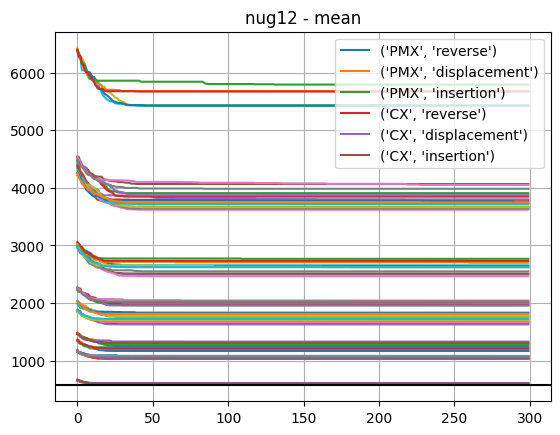

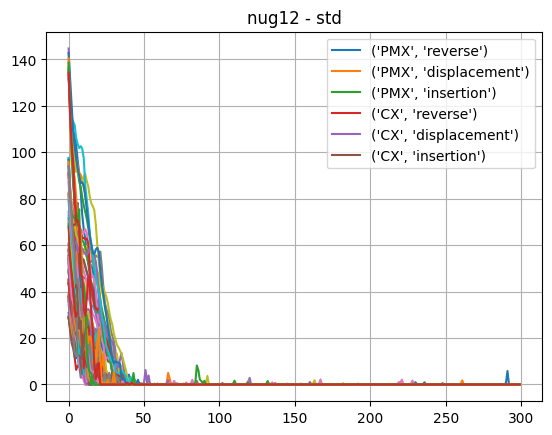

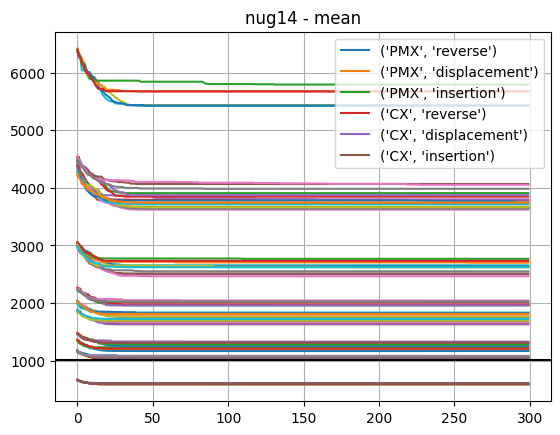

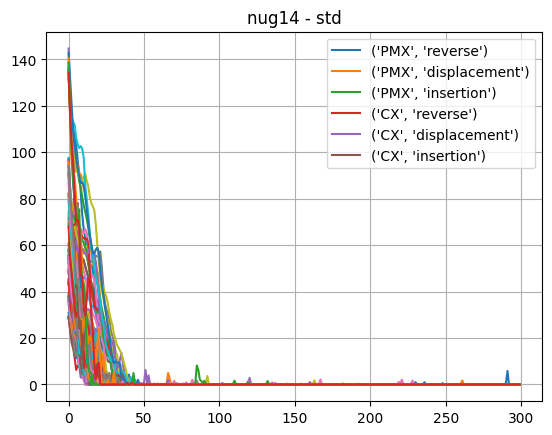

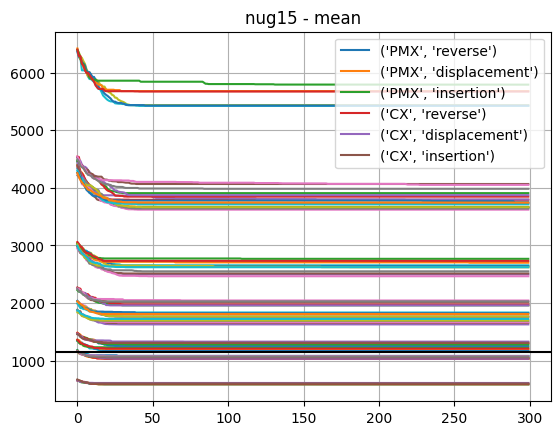

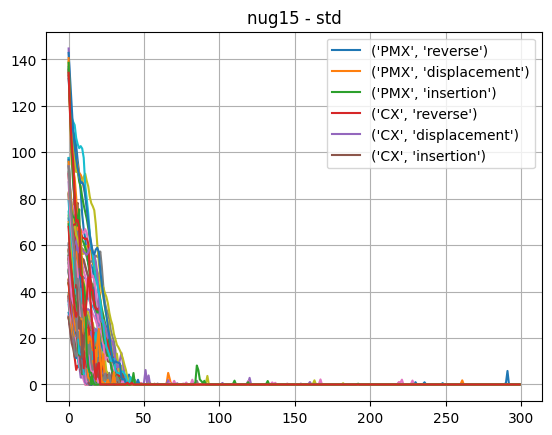

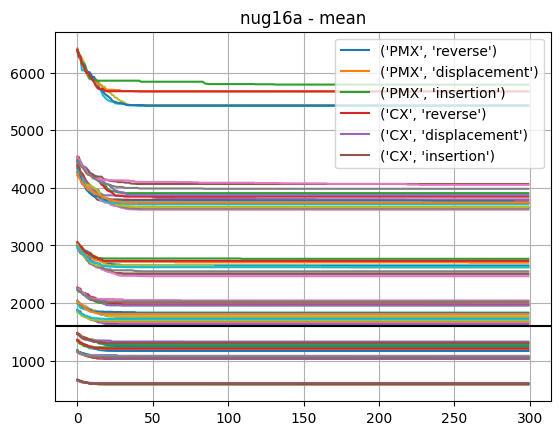

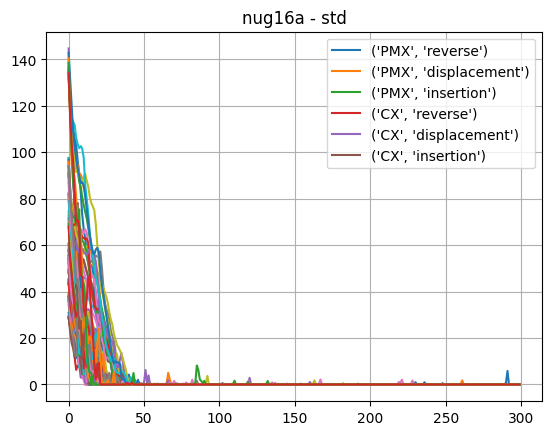

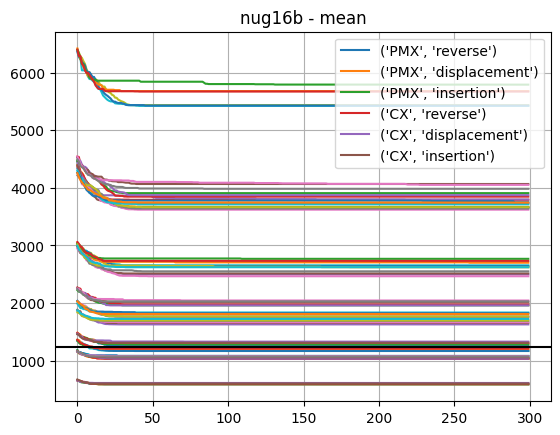

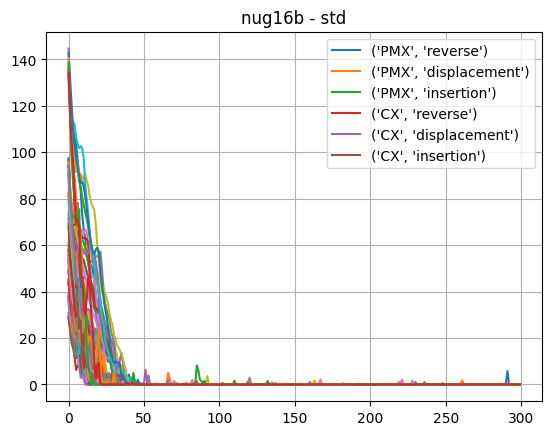

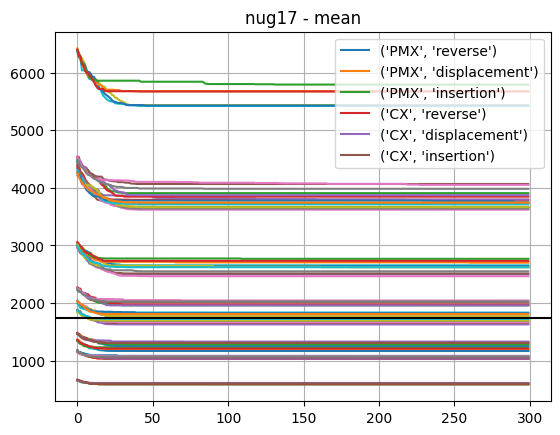

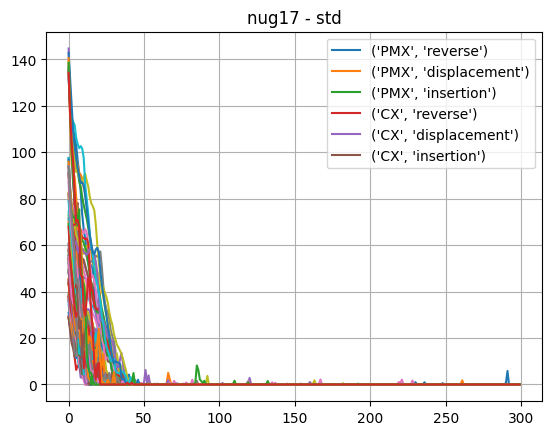

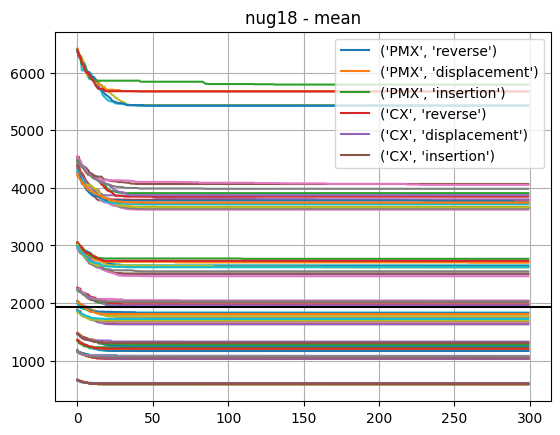

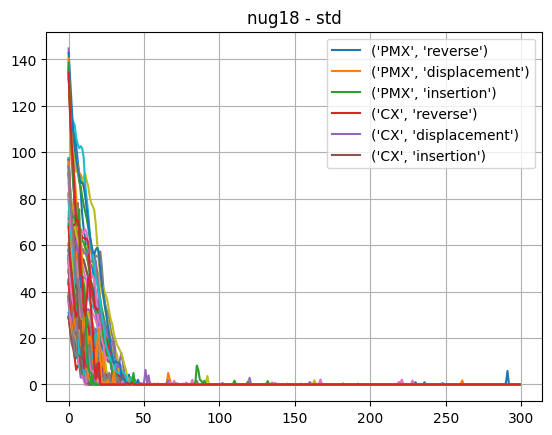

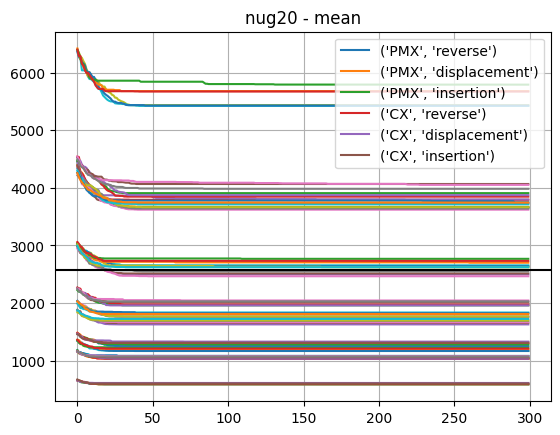

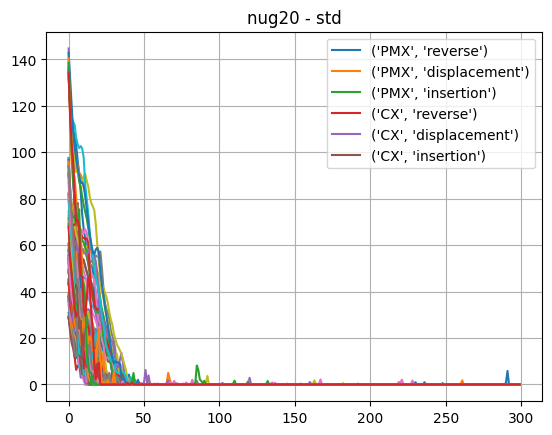

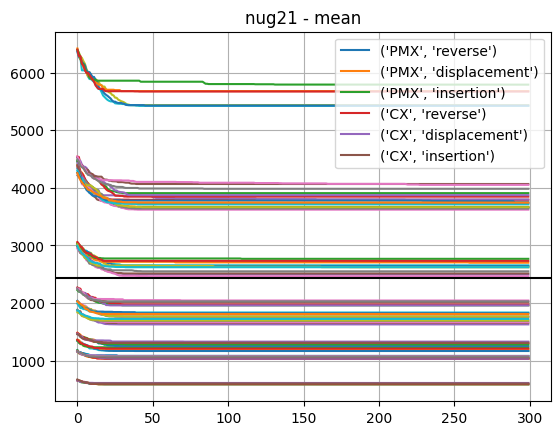

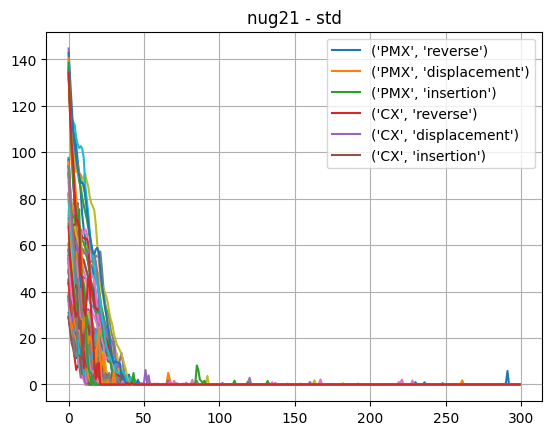

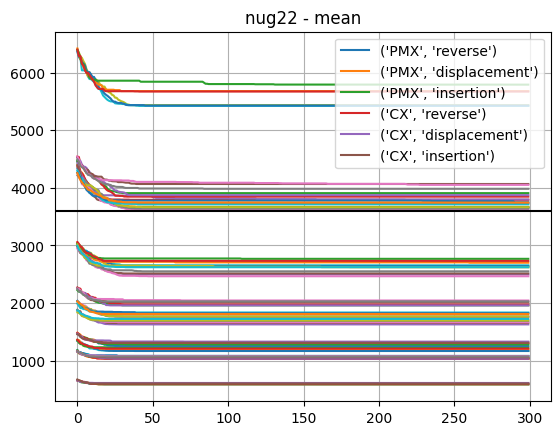

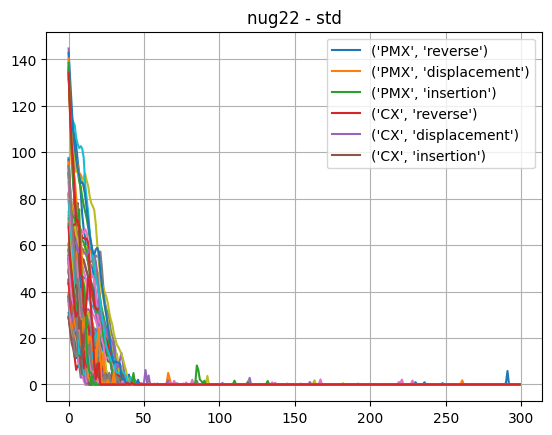

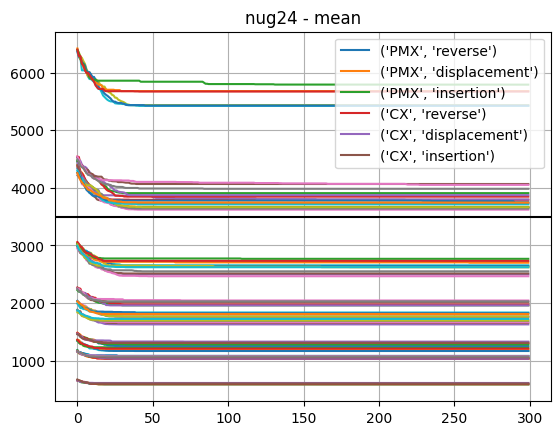

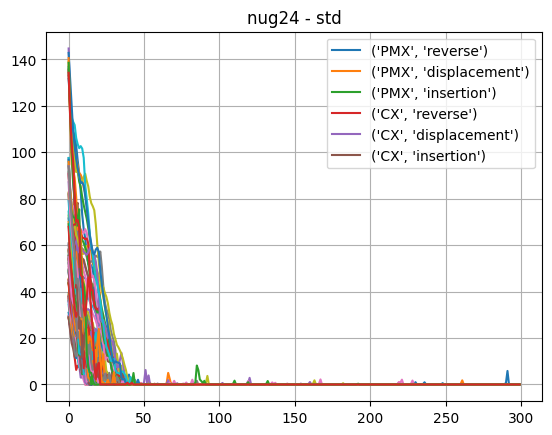

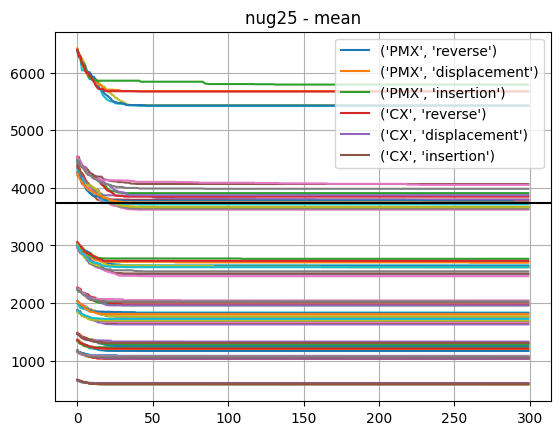

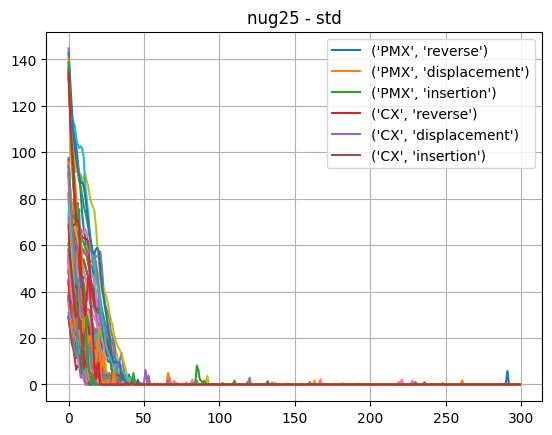

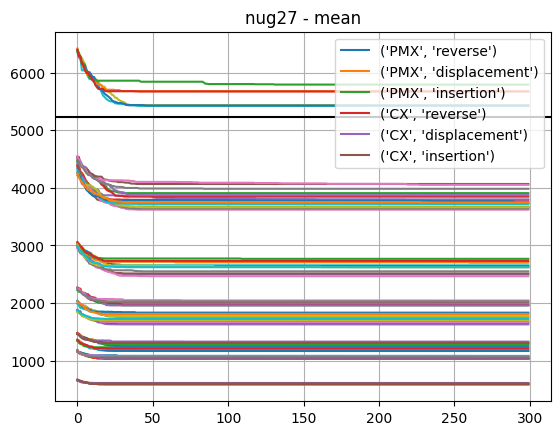

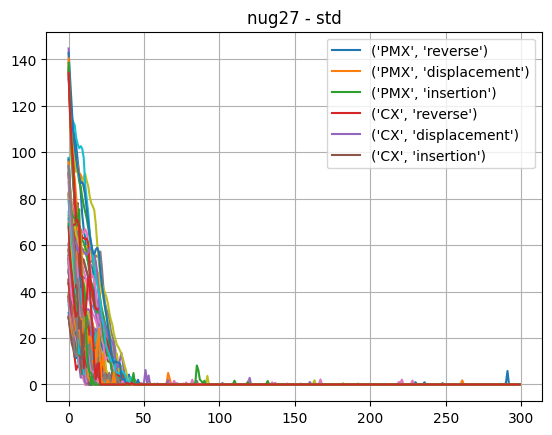

In [25]:
for k, v in costs_stds_dict.items():
    plt.figure()
    plt.title(f"{k} - mean")
    plt.grid()
    
    for c in v[0]:    
        plt.plot((np.nanmean(c, axis=0)))
        
    plt.axhline(y=qaps[k][0], color = 'black', linestyle = '-')
    plt.legend(legend)
    plt.show()

    plt.figure()
    plt.title(f"{k} - std")
    plt.grid()
    
    for s in v[1]:
        plt.plot(np.nanmean(s, axis=0))
        
    plt.legend(legend)
    plt.show()